# UFO mean waveforms

## Import package

In [22]:
import os,sys
import numpy as np
import pynapple as nap
import pandas as pd
from scipy.fft import fft
from xml.dom import minidom
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import nwbmatic as ntm
import scipy.io as sc

dataDirectory = r'D:\PeyracheLab Internship\Data\B0714-230221'

## Exploring the data

In [23]:
sessionInfo = sc.loadmat(dataDirectory + r'\B0714-230221.sessionInfo.mat')
sleepState = sc.loadmat(dataDirectory + r'\B0714-230221.SleepState.states.mat')
sleepStateEp = sc.loadmat(dataDirectory + r'\B0714-230221.SleepStateEpisodes.states.mat')

sleepStateInts = sleepState['SleepState'][0, 0]['ints'][0, 0]
sleepStateEp = sleepStateEp['SleepStateEpisodes'][0,0][0][0,0]


#WAKEstate = sleepStateInts['WAKEstate']
#NREMstate = sleepStateInts['NREMstate']
#REMstate = sleepStateInts['REMstate'] 

WAKEstate = sleepStateEp['WAKEepisode']
NREMstate = sleepStateEp['NREMepisode']
REMstate = sleepStateEp['REMepisode']

REMstate

array([[ 1819,  1880],
       [ 2506,  2639],
       [ 5311,  5344],
       [ 5949,  6018],
       [20159, 20200],
       [21525, 21551],
       [21911, 22067],
       [33617, 33692],
       [34521, 34665],
       [35780, 35825],
       [37146, 37292],
       [38856, 38899],
       [39355, 39430]], dtype=uint16)

## Labelling epochs

In [24]:
# Function to calculate the overlap duration between the epoch and state intervals
def calculate_overlap_duration(epochStart, epochEnd, stateIntervals):
    overlapDuration = 0
    for start, end in stateIntervals:
        overlapStart = max(epochStart, start)
        overlaEnd = min(epochEnd, end)
        if overlapStart < overlaEnd:  # There is an overlap
            overlapDuration += (overlaEnd - overlapStart)
    return overlapDuration

# Function to label each epoch based on the state with the maximum overlap duration
def label_epoch(row, wake, nrem, rem):
    wakeDuration = calculate_overlap_duration(row['start_time'], row['end_time'], wake)
    nremDuration = calculate_overlap_duration(row['start_time'], row['end_time'], nrem)
    remDuration = calculate_overlap_duration(row['start_time'], row['end_time'], rem)
    
    # Creating a dictionary of state to duration
    durations = {'WAKE': wakeDuration, 'NREM': nremDuration, 'REM': remDuration}
    
    # Selecting the state with the maximum duration of overlap
    maxState = max(durations, key=durations.get)
    
    # If no overlap, label as 'Unlabeled'
    if durations[maxState] == 0:
        return "Unlabeled"
    
    return maxState

# Load the epoch data
epochData = pd.read_csv(dataDirectory + r'\Epoch_TS.csv', header=None, names=['start_time', 'end_time'])

# Apply the labeling function to each epoch
epochData['Label'] = epochData.apply(lambda row: label_epoch(row, WAKEstate, NREMstate, REMstate), axis=1)

# Display the first few rows to verify the labels
print(epochData.head())

epochData.to_csv(dataDirectory+r'\Labeled_Epoch_TS.csv', index=False,header=False)

   start_time   end_time Label
0       0.000   9265.464  NREM
1    9265.464  10226.988  WAKE
2   10226.988  11476.728  WAKE
3   11476.728  12322.296  WAKE
4   12322.296  23464.260  NREM


## Loading the data

In [25]:
data = ntm.load_session(dataDirectory,'neurosuite')


In [26]:
nremEp = data.epochs['NREM']

# For figures. It's a small epoch with few ufo (I supposed)
exEp = nap.IntervalSet(start = 303, end = 309, time_units = 's') 


In [27]:
sampleEpoch=nap.IntervalSet(start = 250, end = 500, time_units = 's') 

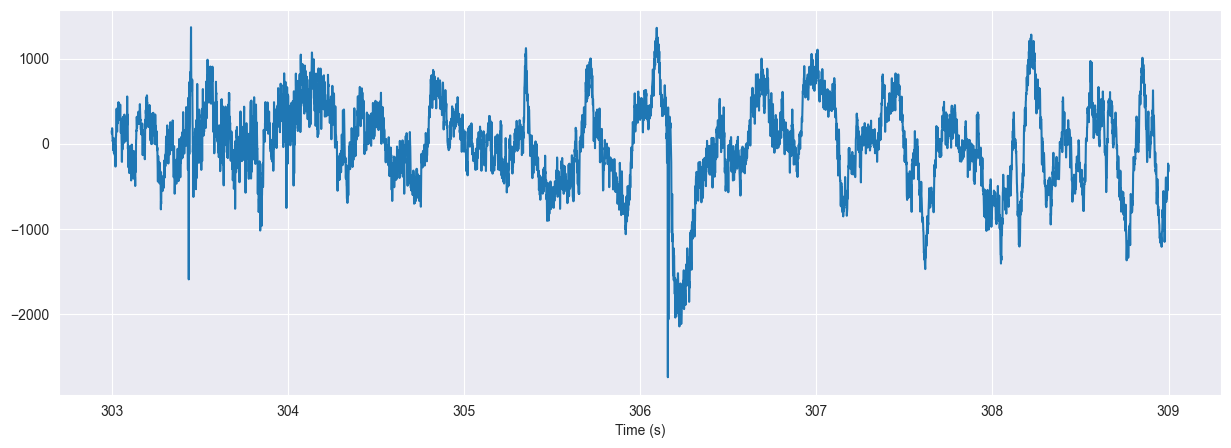

In [7]:
frequency = 1250.0

lfp = data.load_lfp(channel=15,extension='.eeg',frequency=frequency)

#lfpNREM = lfp.restrict(nremEp)
lfpNREM = lfp.restrict(sampleEpoch)

plt.figure(figsize=(15,5))
plt.plot(lfpNREM.restrict(exEp).as_units('s'))
plt.xlabel("Time (s)")
plt.show()

## Step-by-step mean waveform functions

### Generating the mean waveforms

In [18]:
data.load_neurosuite_xml(data.path)
nChannels = data.nChannels #number of channels used to record
fs = data.fs_dat #sampling rate (samples per second)
groupToChannel = data.group_to_channel #how the channels were grouped together
group = data.spikes.get_info('group') #the channel group where each neuron was found

print('Number of channels used in the recording: ', nChannels)
print('Sampling rate: ', fs)
print('Groups of channels: ', groupToChannel)
print('Group of each neuron: \n', group)

AttributeError: 'IntervalSet' object has no attribute 'load_neurosuite_xml'

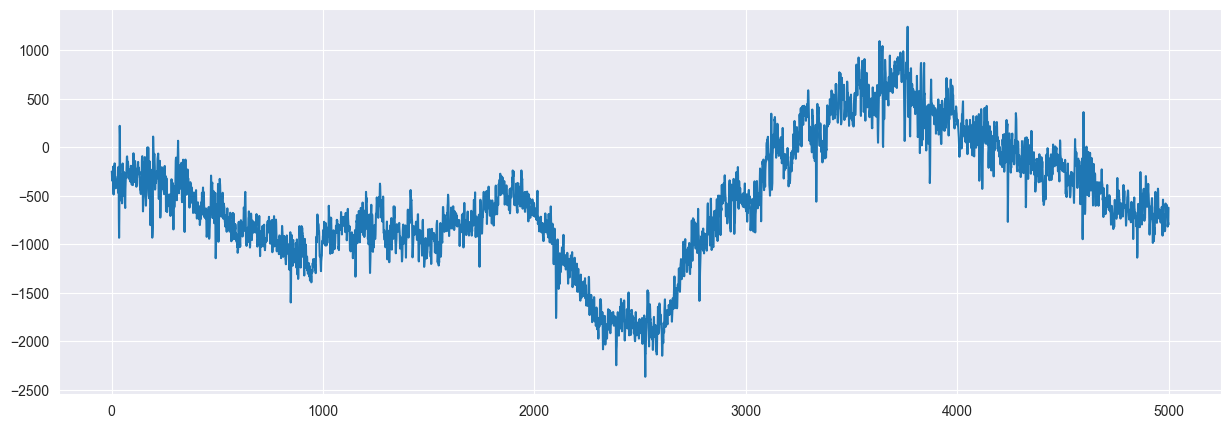

In [9]:
files = os.listdir(dataDirectory)
datFiles    = np.sort([f for f in files if 'dat' in f and f[0] != '.']) #find all dat files in directory

#In order to read the dat file, we need to know the number of samples collected in the recording
file = os.path.join(dataDirectory, datFiles[0])
f = open(file, 'rb') #open dat file in read binary mode
startoffile = f.seek(0, 0)
endoffile = f.seek(0, 2)
bytesSize = 2
nSamples = int((endoffile-startoffile)/nChannels/bytesSize) #This is the number of samples collected
f.close()     

#map to memory all samples for all channels. Channels are numbered according to neuroscope number
fp = np.memmap(file, np.int16, 'r', shape = (nSamples, nChannels))

#let's visualize a small window of the first channel
plt.figure(figsize = (15,5))
plt.plot(fp[22000:27000,0])

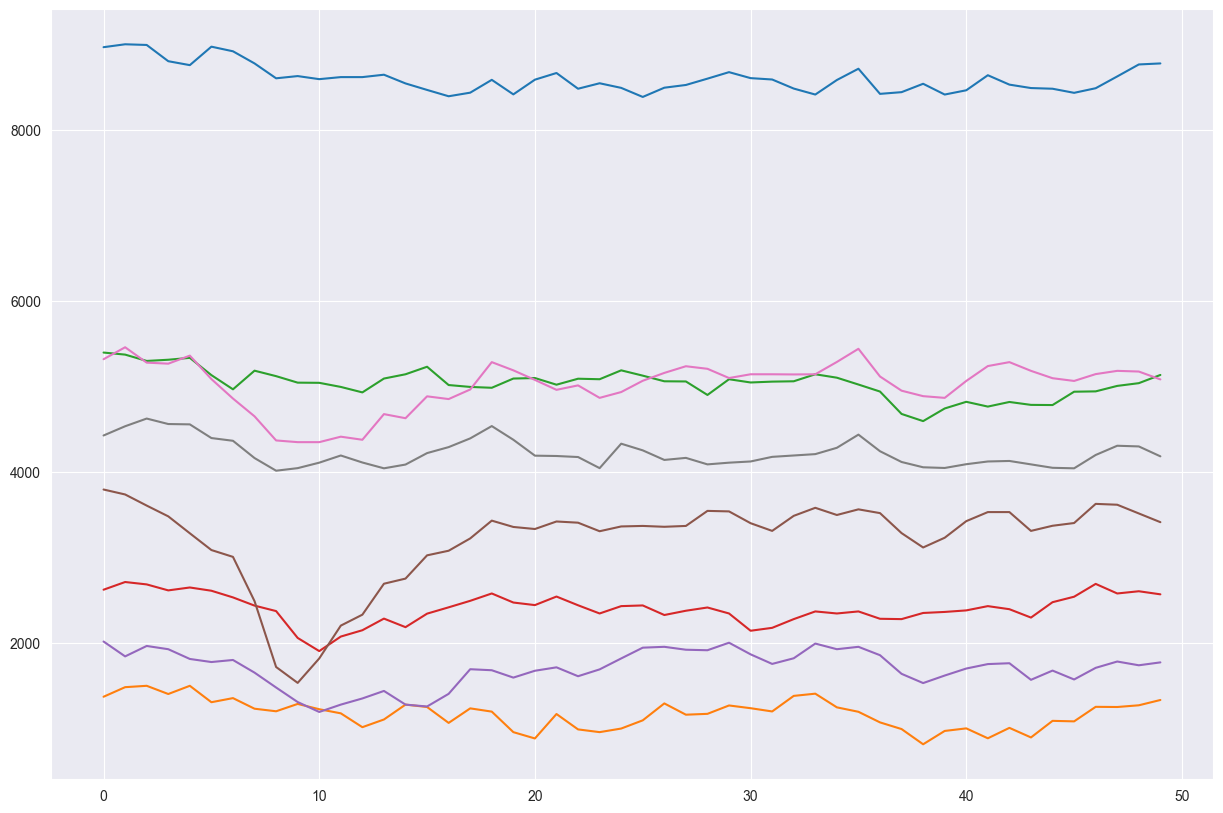

In [10]:
#convert spike times to spikes by sample number
spikes = data.spikes
sampleSpikes = {neuron:(spikes[neuron].as_units('s').index.values*fs).astype('int') for neuron in spikes}

#waveform window in samples taken before and after the spike times
waveformWindow = (np.array([0.0005, 0.002]) * fs).astype(int) #waveform window in seconds * sampling rate


#let's check this window with a random spike from one of the neurons
randomNeuron = 0 #taking the first neuron
randomSpike = sampleSpikes[randomNeuron][5] #fifth spike from the neuron picked
testWindow = [randomSpike - waveformWindow[0],
              randomSpike + waveformWindow[1]]
test_shank = groupToChannel[group[randomNeuron]] #need to know what channels we should expect the spike to be in

#Plot the waveform, offsetting each channel so that they do not overlap in the plot
plt.figure(figsize = (15,10))
channel_offset = np.tile(test_shank, (len(fp[testWindow[0]:testWindow[1]]),1))*800
plt.plot((fp[testWindow[0]:testWindow[1], test_shank])*2+channel_offset)

In [11]:
overlap = sum(waveformWindow) #Overlap of dat batches will be the duration of one waveform
batchSize = 3000000 #Number of samples that will be loaded at one time. This number can be adjusted based on computing power

#Let's determine the sample numbers of each of our batches
batchWindows = np.arange(0, int(endoffile/nChannels/bytesSize), batchSize)
batches = []
for i in batchWindows: #Make overlapping batches from the beginning to the end of the recording
    if i == batchWindows[-1]: #The last batch cannot overlap with the next one
        batches.append([i, nSamples])
    else:
        batches.append([i, i+batchSize+overlap])

print(batches)#let's make sure the dat batches overlap and that everything looks ok

[[0, 3000050], [3000000, 6000050], [6000000, 9000050], [9000000, 12000050], [12000000, 15000050], [15000000, 18000050], [18000000, 21000050], [21000000, 24000050], [24000000, 27000050], [27000000, 30000050], [30000000, 33000050], [33000000, 36000050], [36000000, 39000050], [39000000, 42000050], [42000000, 45000050], [45000000, 48000050], [48000000, 51000050], [51000000, 54000050], [54000000, 57000050], [57000000, 60000050], [60000000, 63000050], [63000000, 66000050], [66000000, 69000050], [69000000, 72000050], [72000000, 75000050], [75000000, 78000050], [78000000, 81000050], [81000000, 84000050], [84000000, 87000050], [87000000, 90000050], [90000000, 93000050], [93000000, 96000050], [96000000, 99000050], [99000000, 102000050], [102000000, 105000050], [105000000, 108000050], [108000000, 111000050], [111000000, 114000050], [114000000, 117000050], [117000000, 120000050], [120000000, 123000050], [123000000, 126000050], [126000000, 129000050], [129000000, 132000050], [132000000, 135000050],

In [12]:
#Taking a subset of spikes for each neuron
spikeCount = 1000 #Compute the mean waveform using 1000 spikes from each neuron

countedSpikes = {} #Take random spikes from each neuron throughout the recording
for index, neuron in enumerate(sampleSpikes):
    if len(sampleSpikes[neuron]) >= spikeCount:
        countedSpikes[neuron] = np.array(np.random.choice(list(sampleSpikes[neuron]), spikeCount))
    elif len(sampleSpikes[neuron]) < spikeCount: #Take all spikes from the neuron if total spikes < spike_count
        print('Not enough spikes in neuron ' + str(index) + '... using all spikes')
        countedSpikes[neuron] = sampleSpikes[neuron]

In [ ]:
#Concatenate all spike times of all neurons - will be used to check for spikes before loading the dat
spikeCheck = np.array([int(spikesNeuron) 
                        for spikesNeuron in countedSpikes[neuron] 
                        for neuron in countedSpikes])

#Initialize the variable where the mean waveforms will be stored
neuronWaveforms = {n: np.zeros([np.sum(waveformWindow), len(groupToChannel[group[n]])]) for n in sampleSpikes}

for index, timestep in enumerate(batches):
    print(f'Extracting waveforms from dat file: window {index+1} / {len(batchWindows)}', end = '\r')

    if len(spikeCheck[(timestep[0]<spikeCheck) & (timestep[1]>spikeCheck)]) == 0:
        continue #if there are no spikes for any neurons in this batch, skip and go to the next one

    #Load dat file for timestep
    tmp = pd.DataFrame(data = fp[timestep[0]:timestep[1],:], 
                       columns = np.arange(nChannels), 
                       index = range(timestep[0],timestep[1])) 

    #Check for spikes neuron by neuron
    for neuron in countedSpikes:
        neurontmp = countedSpikes[neuron]
        tmp2 = neurontmp[(timestep[0]<neurontmp) & (timestep[1]>neurontmp)] #spikes present in this batch
        
        if len(neurontmp) == 0:
            continue #skip neuron if it has no spikes in this batch
        
        #Restrict dat file to the channel group of the neuron
        tmpn = tmp[groupToChannel[group[neuron]]]

        for time in tmp2: #add each spike waveform to neuron_waveform
            spikewindow = tmpn.loc[time-waveformWindow[0]:time+waveformWindow[1]-1] #waveform for this spike time
            try:
                neuronWaveforms[neuron] += spikewindow.values
            except: #ignore if full waveform is not present in this batch
                pass

            
#Convert our waveforms to a nicer format. We will also replace sample number back into seconds
meanwf = {n: pd.DataFrame(data = np.array(neuronWaveforms[n])/spikeCount,
                                  columns = np.arange(len(groupToChannel[group[n]])),
                                  index = np.array(np.arange(-waveformWindow[0], waveformWindow[1]))/fs) for n in countedSpikes}




#Let's visualize the mean waveforms of the neurons
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    channel_offset = np.tile(groupToChannel[group[neuron]],
                            (len(meanwf[neuron].index),1))*500
    plt.plot(meanwf[neuron]+channel_offset)
plt.tight_layout()

In [ ]:
maxch = pd.Series(data = [meanwf[n][meanwf[n].loc[0].idxmin()].name for n in meanwf], 
                  index = spikes.keys())

maxwf = {neuron: meanwf[neuron][maxch[neuron]] for neuron in meanwf}

#Let's visualize the mean waveforms of the neurons
plt.figure(figsize = (15,9))
for i,neuron in enumerate(maxwf):
    plt.subplot(5,3,i+1)
    plt.plot(maxwf[neuron])
plt.tight_layout()

## Pynapple functions for mean waveform

In [28]:
meanwf, maxch = data.load_mean_waveforms(sampleEpoch)

Restricting spikes to epoch
Restricting dat file to epoch
Not enough spikes in neuron 3... using all spikes
Not enough spikes in neuron 4... using all spikes
Not enough spikes in neuron 7... using all spikes
Not enough spikes in neuron 8... using all spikes
Not enough spikes in neuron 9... using all spikes
Not enough spikes in neuron 10... using all spikes
Not enough spikes in neuron 15... using all spikes
Not enough spikes in neuron 17... using all spikes
Not enough spikes in neuron 19... using all spikes
Not enough spikes in neuron 20... using all spikes
Not enough spikes in neuron 21... using all spikes
Not enough spikes in neuron 22... using all spikes
Not enough spikes in neuron 23... using all spikes
Not enough spikes in neuron 24... using all spikes
Not enough spikes in neuron 26... using all spikes
Not enough spikes in neuron 28... using all spikes
Not enough spikes in neuron 31... using all spikes
Not enough spikes in neuron 33... using all spikes
Not enough spikes in neuron 3

In [ ]:
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    channelOffset = np.tile(np.array(meanwf[neuron].columns),
                            (len(meanwf[neuron].index),1))*500
    plt.plot(meanwf[neuron]+channelOffset)
plt.tight_layout()

In [ ]:
plt.figure(figsize = (15,9))
for i,neuron in enumerate(meanwf):
    plt.subplot(5,3,i+1)
    plt.plot(meanwf[neuron][maxch[neuron]])
plt.tight_layout()